# Univariate time series forecasting with LSTM
This tutorial example presents how to perform forecasts for an univariate time series while using a LSTM neural network.  

The calibration of the LSTM neural network relies on the raw traning set that is deemed to be trend-stationnary. 

In this example, we use a simple sine-like signal onto which we added a synthetic linear trend.

### Import libraries
Import the various libraries that will be employed in this example.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from pytagi import Normalizer as normalizer
import pytagi.metric as metric

### Import from Canari
From Canari, we need to import several classes that will be reused in this example. Notably, we need to import the components that will be used to build the model; In terms of baseline, we use the `LocalTrend` and components. The recurrent pattern is modelled using a `LstmNetwork` and the residual is modelled by a `WhiteNoise` compoment.

In [2]:
from canari import (
    DataProcess,
    Model,
    plot_data,
    plot_prediction,
    plot_states,
)
from canari.component import LocalTrend, LstmNetwork, WhiteNoise

### Read data
The raw `.csv` data is saved in a dataframe using the Panda external library.

In [3]:
project_root = Path.cwd().resolve().parents[1]
data_file = str(project_root / "data/toy_time_series/sine.csv")
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
# Add a trend to the data
linear_space = np.linspace(0, 2, num=len(df))
df = df.add(linear_space, axis=0)
#
data_file_time = str(project_root / "data/toy_time_series/sine_datetime.csv")
time_index = pd.read_csv(data_file_time, skiprows=1, delimiter=",", header=None)
time_index = pd.to_datetime(time_index[0])
df.index = time_index
df.index.name = "time"
df.columns = ["values"]

### Data preprocess
In terms of pre-processsing, we define here our choice of using the first 80% of the raw time series for trainig and the following 10% for the validation set. The remaining last 10% are the implicitely defined as the test set. 

In [4]:
output_col = [0]
data_processor = DataProcess(
    data=df,
    train_split=0.8,
    validation_split=0.1,
    output_col=output_col,
)
train_data, validation_data, test_data, standardized_data = data_processor.get_splits()
data_processor.data.head()

,values
time,
2000-01-03 00:00:00,0.000000
2000-01-03 01:00:00,-0.250698
2000-01-03 02:00:00,-0.481395
2000-01-03 03:00:00,-0.682093
2000-01-03 04:00:00,-0.832791


### Define model from components
We instantiatiate each component from their corresponding class. The `local_trend` baseline component relies on the default hyperparameters. The recurrent `pattern` will use a 1-layer LSTM neural network with 50 hidden units with a look-back length of 19 time steps. The look-back window consists in the set of past neural network's outputs that are employed as explanatory variables in order to predict the current output. The `residual` is modelled by a Gaussian white noise with a mean 0 and a user-defined standard deviation of 0.05. 

Note that we use `auto_initialize_baseline_states` in order to automatically initialize the baseline hidden states based on the first day of data.

In [5]:
local_trend = LocalTrend()
pattern = LstmNetwork(
        look_back_len=19,
        num_features=1,
        num_layer=1,
        num_hidden_unit=50,
        manual_seed=1,
    )
residual = WhiteNoise(std_error=0.05)

model = Model(local_trend, pattern, residual)
model.auto_initialize_baseline_states(train_data["y"][0 : 24])

### Training the LSTM neural network
The training of the LSTM neural network model is done using the training and validation sets. The training set is used to perform the time series decomposition into a baseline, pattern and residual and to simultanously learn the LSTM neural network parameters. The validation set is used in order to identify the optimal training epoch for the LSTM neural network. Note that it is essential to perform this training on a dataset that is either stationnary or trend-stationnary.

In [6]:
num_epoch = 50
for epoch in range(num_epoch):
    (mu_validation_preds, std_validation_preds, states) = model.lstm_train(
        train_data=train_data,
        validation_data=validation_data,
    )
    
    # Unstandardize the predictions
    mu_validation_preds = normalizer.unstandardize(
        mu_validation_preds,
        data_processor.scale_const_mean[output_col],
        data_processor.scale_const_std[output_col],
    )
    std_validation_preds = normalizer.unstandardize_std(
        std_validation_preds,
        data_processor.scale_const_std[output_col],
    )

    # Calculate the log-likelihood metric
    validation_obs = data_processor.get_data("validation").flatten()
    mse = metric.mse(mu_validation_preds, validation_obs)

    # Early-stopping
    model.early_stopping(evaluate_metric=mse, current_epoch=epoch, max_epoch=num_epoch)
    if epoch == model.optimal_epoch:
        mu_validation_preds_optim = mu_validation_preds
        std_validation_preds_optim = std_validation_preds

    if model.stop_training:
        break

### Set relevant variables for predicting in the test set
In order to forecast on the test set, we need to set the LSTM and SSM states to the values corresponding to the last time step of the validation set. Note that the values corresponds to those associated with the optimal training epoch as identified using the validation set. 

In [7]:
model.set_memory(
    time_step=data_processor.test_start - 1,
)

### Forecast on the test set
We perform recursive 1-step ahead forecasts on the test set and then proceed with un-standardization of the data in order to retreive the original scale of the raw data.

In [8]:
mu_test_preds, std_test_preds, states = model.forecast(
    data=test_data,
)

# Unstandardize the predictions
mu_test_preds = normalizer.unstandardize(
    mu_test_preds,
    data_processor.scale_const_mean[output_col],
    data_processor.scale_const_std[output_col],
)
std_test_preds = normalizer.unstandardize_std(
    std_test_preds,
    data_processor.scale_const_std[output_col],
)

### Predictions and hidden states
We represent the time-series decomposition visually where the raw data is overlaid with the baseline hidden state represented by the _level_. The rate of change of the baseline is characterized by the _trend_ hidden states. The recurrent pattern is captured by the LSTM neural network. The posterior estimate for the residuals are displayed for the white noise component. The forecast period corresponds to the last day of data following the validation set, which is depicted by the green-shaded region.

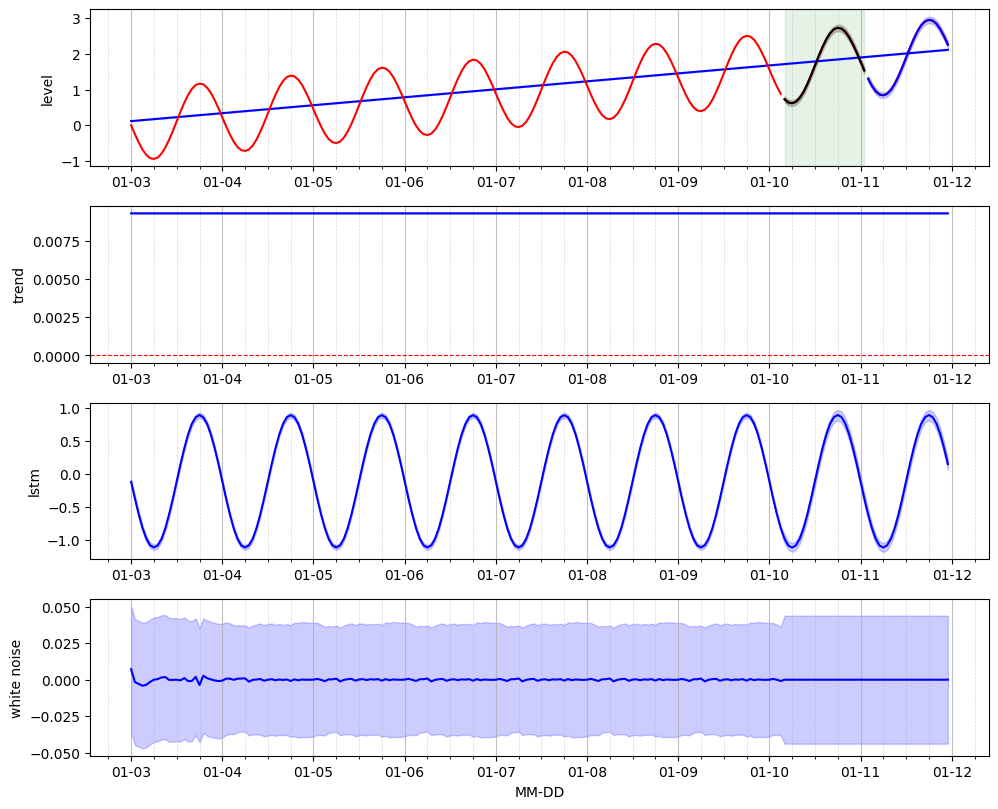

In [9]:
fig, ax = plot_states(
    data_processor=data_processor,
    states=states,
    )
plot_data(
    data_processor=data_processor,
    plot_train_data=True,
    plot_test_data=True,
    plot_validation_data=True,
    sub_plot=ax[0]
    )
plot_prediction(
    data_processor=data_processor,
    mean_validation_pred=mu_validation_preds,
    std_validation_pred = std_validation_preds,
    sub_plot=ax[0],
    color="k",
    )
plot_prediction(
    data_processor=data_processor,
    mean_test_pred=mu_test_preds,
    std_test_pred = std_test_preds,
    sub_plot=ax[0],
    color="b",
    )
ax[-1].set_xlabel("MM-DD")
plt.show()